In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset

# Initial setup

In [8]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory
# model_path = machine_path + "/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst"
# model_path = machine_path + "/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean"
# model_path = machine_path + "/Doutorado/cenarios/mandyoc/stable/lit80km/stable_DT500_rheol19_c1250_C1_HprodAst_Hlit80km"

# model_path = machine_path + '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit150km/DT290_PT1421oC/ACC_Clc1_DT290_PT1421oC_lit150km_4x4km2'
model_path = machine_path + '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/no_mean_temp_litho/lit150km/DT290_PT1421oC/ACC_Clc10_DT290_PT1421oC_lit150km_4x4km2'


read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True

# Datasets handeling
## Model path

In [9]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")

if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select with ones you would like to plot
#              'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
#              'strain',
             'strain_rate',
#              'temperature',
#              'temperature_anomaly',
#              'surface',
#              'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets
new_datasets = change_dataset(properties, datasets)

for dataset in datasets:
    if not os.path.isfile(f"{model_path}/_output_{dataset}.nc"):
        print(f"Could not find dataset {dataset}. Creating missing dataset.")
        ds_data = read_mandyoc_output(
            model_path,
            datasets=dataset,
            parameters_file="param.txt"
        )     

if (save_big_dataset):
    dataset = read_datasets(model_path, new_datasets, save_big_dataset = True) 
else:
    dataset = read_datasets(model_path, new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset.data_vars:
    v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
    dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
    dataset.velocity_z[:] = dataset.velocity_z[:] / v_max
print(dataset.info)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (x: 401, time: 241, z: 176)
Coordinates:
  * x            (x) float64 0.0 4e+03 8e+03 ... 1.592e+06 1.596e+06 1.6e+06
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 118.4 118.9 119.4 119.9
    step         (time) int32 0 100 200 300 400 ... 23700 23800 23900 24000
  * z            (z) float64 -7e+05 -6.96e+05 -6.92e+05 ... -8e+03 -4e+03 0.0
Data variables:
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
    strain_rate  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                176
    lx:                                1600000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:       

# Plot data

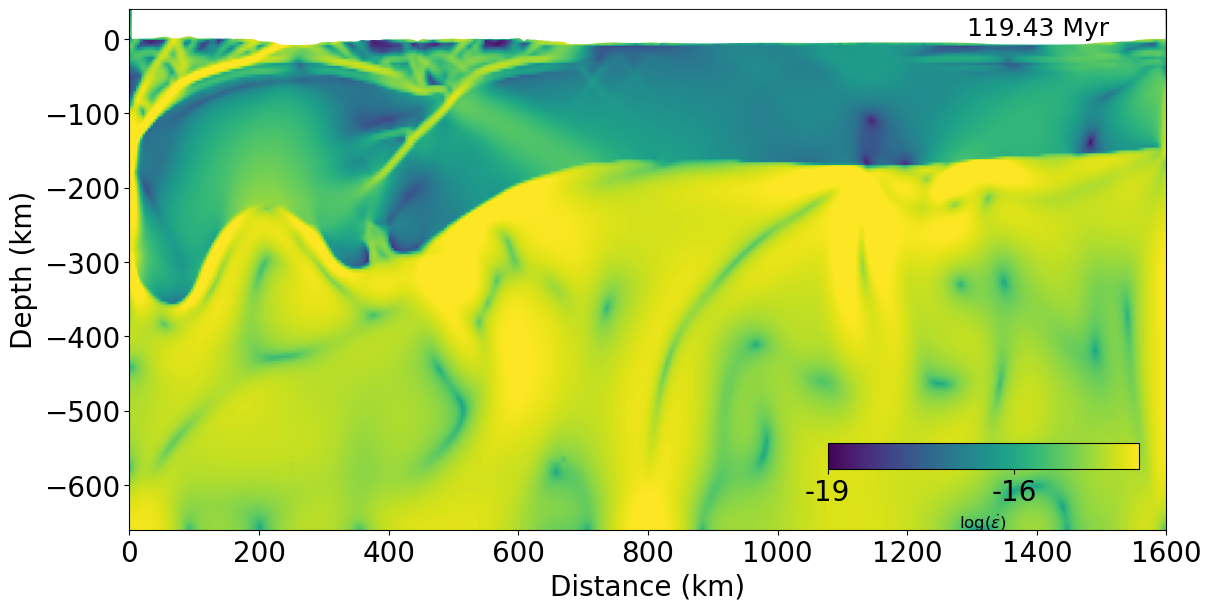

In [10]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 1

# start = 0
# end = 1
# step = 1

# step_initial = dataset.step[0]
# step_1 = dataset.step[1]
# step_final = dataset.step[-1]
# dstep = int(step_1 - step_initial)

for i in range(start, end, step):
    data = dataset.isel(time=i)
    per = np.round(100*(i+1-start)/(end-start), 2)
    text = f"Time: {np.round(float(data.time), 2)} Myr; Step: {int(data.step)}/{int(dataset.step.max())}, ({per:.2f}%)."
    
    print(text, end='\r')
    
    for prop in properties:
#         print(f"Handeling {prop}.", end='\n')
        if(prop != 'surface'): # you can customize
            xlims = [0, float(data.lx) / 1.0e3]
            ylims = [-float(data.lz) / 1.0e3 + 40, 40]
        else:
            xmin = 0 #+ 200
            xmax = float(data.lx) / 1.0E3 #- 200
            xlims = [xmin, xmax]
            ylims = [-7, 7]
            
        single_plot(data, prop, xlims, ylims, model_path, output_path)
#     print((n+1)*'\033[F', end='')

# Making video

In [ ]:
for prop in properties:
    line = f"ffmpeg -r 30 -f image2 -s 1920x1080 -pattern_type glob -i '{model_path}/_output/{model_name}_{prop}_*.png' -vcodec libx264 -crf 25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4"
#     print(line)
    
    !rm {model_path}/_output/{model_name}.mp4
    !ffmpeg -r 30 -f image2 -s 1920x1080 -pattern_type glob -i '{model_path}/_output/{model_name}_{prop}_*.png' -vcodec libx264 -crf 25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4
    
#     !rm {model_path}/_output/{model_name}.gif
#     !ffmpeg -ss 0 -t 10 -i '{model_path}/_output/{model_name}.mp4' -vf "fps=100,scale=1080:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 {model_path}/_output/{model_name}.gif